This kernel explores the Myers-Briggs Personality Type Dataset. The data was extracted from comments let by users with different MBTI personality.

I used a simple model which trains relatively quickly. The cross validation output an f1-score of ~0.65. It is possible to search for hyper paramaters with bayesian optimisation to improve accuracy. Also, a pre-trained words embedding like glove in an neural model may bring more insight. A lot of the links are dead links but it would be interesting to scrap the different urls to extract more information. 

# Text Analysis with (MBTI) Myers-Briggs Personality Type Dataset

## Description 



Ii is implemented in Python 3.6.

The main steps are :

1. Treat data
* Load data using pandas
* Split each row by type | comments 
* Cleaning each comments by :
    * removing all urls replaced by dummy word 'link' -> erase (replace by '')
    * removing everything except letters
    * removing larger spaces and lowering
    * removing stopwords and lemmatizing
    * Labelizing each mbti personality

2. Learning phase:
    - 16 classes (mutliclass):
        * Run tf-idf and count vectorization of words vectorization 
        * Compute pca, fast\_ica, tsne
        * Multinomial Naive Bayes (F1-score ~ 0.603) [5 fold stratified cross validation]
        * XGboost (F1-score ~ 0.656) [5 fold stratified cross validation]
        
    - 4 binary classes (mutlioutput binary classification):
        * 4 Adaboost model with a multioutput classifier
        
As the letters are only paired by two, the problem is to predict 4 binary variables. The cross validation gives the following table. 
          
|Attribute| Extraversion (E) - Introversion (I)  | Sensation (S) - INtuition (N)  | Thinking (T) - Feeling (F)  | Judgement (J) - Perception (P)  |   
|:-:|---|---|---|---|
|F1-Score|0.59 | 0.44 | 0.8 |  0.83| 

This allows us to see what are the axes that the algorithm may fail at identifying (S Sensation vs N Intuition).

Finally there are two neural networks, (1D convnet and LSTM) but I did not have the time to tune them.

TO DO:
- Scrape urls and extract topic of pages
- Balance the dataset with resampling techniques
- Hyper Parameter Optimization
- Convolutional Network with glove embedding
- Search multiple classifiers (not correlated) and stack them and build pipeline with Lasso.

In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns

%matplotlib inline

# read data
data = pd.read_csv('mbti_1.csv') # dtype = {'type': str,'post': ,

## Overview of the data

In [6]:
data.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### List of posts

In [7]:
[p.split('|||') for p in data.head(1).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

# Distribution of the target variable?

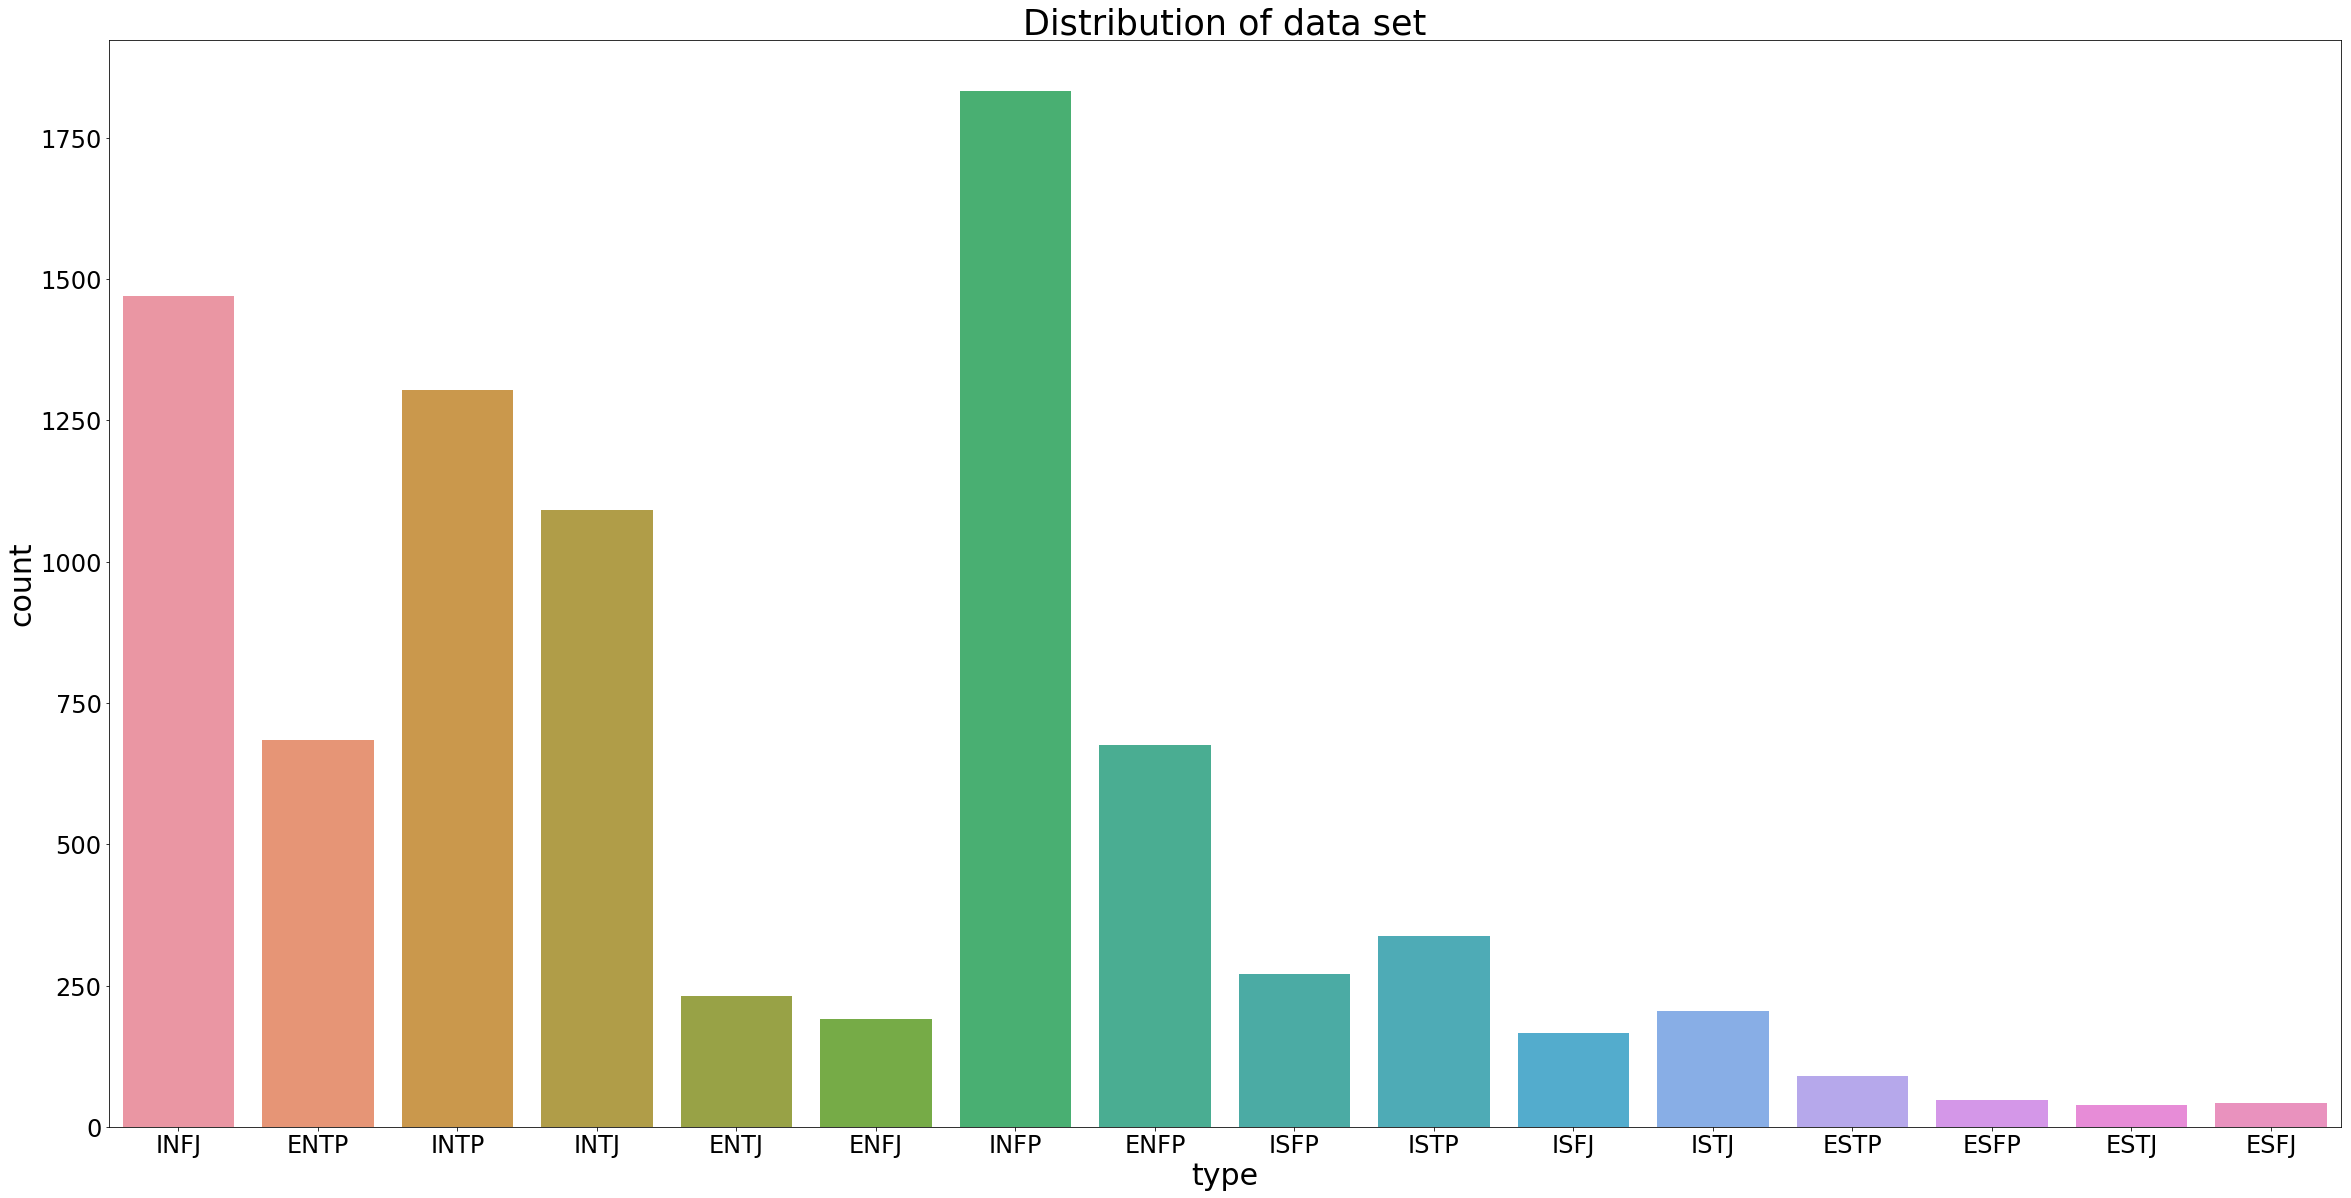

In [8]:
plt.figure(figsize=(40,20))
plt.xlabel('type', size = 30)
plt.ylabel('type', size = 30)
plt.title('Distribution of data set', size=35)
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

#### It is clearly unbalanced throughout the different classes. 

# Preprocessing

### Label Encoding

In [9]:
##### Encode each type to an int

from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)


### Posts cleaning

In [10]:
# import nltk
# nltk.download('stopwords')
# stopwords.words('english')[:10]
# nltk.download('wordnet')

In [11]:
import time
##### Compute list of subject with Type | list of comments 

# Time
%time data.posts[1].replace('+', ' ').replace('.', ' ').replace(',', ' ').replace(':', ' ')
%time re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', data.posts[1])


from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Lemmatizer | Stemmatizer
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

# One post
OnePost = data.posts[1]

# List all urls
urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', OnePost)

# Remove urls
temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', OnePost)

# Keep only words
temp = re.sub("[^a-zA-Z]", " ", temp)

# Remove spaces > 1
temp = re.sub(' +', ' ', temp).lower()

# Remove stopwords and lematize
%time stemmer.stem(" ".join([w for w in temp.split(' ') if w not in cachedStopWords]))

print("\nBefore preprocessing:\n\n", OnePost[0:500])
print("\nAfter preprocessing:\n\n", temp[0:500])
print("\nList of urls:")
urls

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 375 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 472 µs
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.39 ms

Before preprocessing:

 'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + L

After preprocessing:

  i m finding the lack of me in these posts very alarming sex can be boring if it s in the same position often for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary there isn t enough giving new 

['http://img188.imageshack.us/img188/6422/6020d1f9da6944a6b71bbe6.jpg',
 'http://img.adultdvdtalk.com/813a0c6243814cab84c51',
 'http://i817.photobucket.com/albums/zz96/kamioo/Dirtywinch.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Thunderstorm.pnghttp://i817.photobucket.com/albums/zz96/kamioo/Thunderstormbw.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Cosmicstorm.png',
 'http://www.youtube.com/watch?v=j5W73HaVQBg',
 'http://i817.photobucket.com/albums/zz96/kamioo/Deathgrip.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Deathgripbw.png',
 'http://i817.photobucket.com/albums/zz96/kamioo/Statickitten.png']

### Preprocessing comments

* Replace urls with a dummy word: "link"
* Keep only words and put everything lowercase
* Lemmatize each word 


In [12]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        type_labelized = lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        list_posts.append(temp)

    #del data
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_data(data, remove_stop_words=True)

500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows


In [13]:
list_posts

array([' enfp intj moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace hello enfj sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear enfp favorite video game growing current favorite video game cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo entp lady c

### Vectorize with count and tf-idf

I kept the words appearing in 10 to 50% of the posts. 

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

cntizer = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,  
#                             ngram_range=(1,1),
                             max_df=0.5,
                             min_df=0.1) 
                                 
tfizer = TfidfTransformer()

print("CountVectorizer")
X_cnt = cntizer.fit_transform(list_posts)
print("Tf-idf")
X_tfidf =  tfizer.fit_transform(X_cnt).toarray()

CountVectorizer
Tf-idf


In [15]:
X_tfidf.shape

(8675, 754)

In [16]:
list_posts[0]

' enfp intj moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing infj friend posted facebook committing suicide next day rest peace hello enfj sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear enfp favorite video game growing current favorite video game cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo entp lady complime

### Count the top 50 words of the count vectorizer

In [17]:
reverse_dic = {}
for key in cntizer.vocabulary_:
    reverse_dic[cntizer.vocabulary_[key]] = key

In [18]:
top_50 = np.asarray(np.argsort(np.sum(X_cnt, axis=0))[0,-50:][0, ::-1]).flatten()
[reverse_dic[v] for v in top_50]

['infp',
 'infj',
 'intj',
 'intp',
 'relationship',
 'lol',
 'enfp',
 'yeah',
 'thanks',
 'oh',
 'bit',
 'may',
 'entp',
 'agree',
 'quite',
 'guess',
 'talk',
 'school',
 'great',
 'thank',
 'personality',
 'use',
 'function',
 'bad',
 'everything',
 'interesting',
 'believe',
 'definitely',
 'happy',
 'reason',
 'part',
 'used',
 'often',
 'seem',
 'experience',
 'last',
 'word',
 'anyone',
 'test',
 'keep',
 'hate',
 'another',
 'girl',
 'forum',
 'enough',
 'put',
 'else',
 'care',
 'talking',
 'getting']

The 4 top words are actually some mbti profiles... This is strange!

Lets try dimensionality reduction:

LSA 하는 부분

In [19]:
print(np.around(X_tfidf, 2))
X_tfidf.shape

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.05 0.   ... 0.   0.   0.  ]
 [0.16 0.06 0.14 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.07 0.   ... 0.   0.   0.  ]
 [0.   0.05 0.   ... 0.   0.06 0.  ]]


(8675, 754)

In [20]:
from sklearn.decomposition import TruncatedSVD
# Truncated SVD
svd = TruncatedSVD(n_components=12, n_iter=7, random_state=42)
svd_vec = svd.fit_transform(X_tfidf)

In [21]:
print(np.around(svd_vec, 2))
svd_vec.shape

[[ 0.38 -0.03 -0.02 ... -0.15  0.06 -0.12]
 [ 0.42  0.12 -0.03 ...  0.16  0.19 -0.15]
 [ 0.38 -0.07 -0.07 ... -0.04 -0.04 -0.03]
 ...
 [ 0.39 -0.09 -0.04 ...  0.21 -0.15  0.04]
 [ 0.49 -0.06 -0.04 ...  0.01  0.02  0.06]
 [ 0.42 -0.16 -0.05 ... -0.02 -0.01  0.  ]]


(8675, 12)

### Plot first axes of decomposition

In [22]:
from sklearn.decomposition import KernelPCA, FastICA, PCA
from sklearn.preprocessing import StandardScaler

# PCA
pca_vec = PCA(n_components=12).fit_transform(X_tfidf)

# ICA
ica_vec = FastICA(n_components=12).fit_transform(X_tfidf)


In [23]:
print(np.around(pca_vec, 2))
pca_vec.shape

[[-0.03 -0.01 -0.06 ...  0.05 -0.1  -0.08]
 [ 0.12 -0.03  0.07 ...  0.2  -0.15  0.06]
 [-0.07 -0.06  0.03 ... -0.04 -0.03 -0.04]
 ...
 [-0.09 -0.02  0.18 ... -0.14  0.03  0.07]
 [-0.05 -0.06 -0.06 ...  0.02  0.06 -0.01]
 [-0.15 -0.05 -0.02 ... -0.01  0.   -0.05]]


(8675, 12)

In [24]:
print(np.around(ica_vec, 2))
ica_vec.shape

[[-0.02  0.   -0.01 ... -0.   -0.01  0.01]
 [ 0.    0.01  0.   ... -0.    0.01  0.  ]
 [-0.    0.    0.   ... -0.   -0.01  0.  ]
 ...
 [ 0.   -0.01  0.01 ...  0.   -0.   -0.02]
 [ 0.01 -0.01  0.01 ... -0.    0.01  0.01]
 [ 0.   -0.    0.   ... -0.   -0.    0.  ]]


(8675, 12)

#### Plot tsne for each pair of letter:

* Extraversion (E) - Introversion (I)
* Sensation (S) - INtuition (N)
* Thinking (T) - Feeling (F)
* Judgement (J) - Perception (P)

In [25]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    '''
    transform mbti to binary vector
    string 성격을 주면 list 성격 코드로 바꿔줌
    '''
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    '''
    transform binary vector to mbti personality
    list 성격 코드를 주면 string 성격으로 바꿔줌
    '''
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)
list_personality_bin.shape
# Plot
# tsne 안해!
# def plot_tsne(X, i):
#     a = plt.figure(i, figsize=(30,20))
#     plt.title(titles[i])
#     plt.subplot(3,1,1)
#     plt.scatter(X[:,0], X[:,1], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)
#     plt.subplot(3,1,2)
#     plt.scatter(X[:,0], X[:,2], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)
#     plt.subplot(3,1,3)
#     plt.scatter(X[:,1], X[:,2], c=list_personality_bin[:,i], cmap=plt.get_cmap('Dark2'), s=25)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


(8675, 4)

전체 데이터 셋의 성격코드 label을 np 행렬로 표현

#### Confusion plot function
Confusion plot이 필요한가?

In [26]:
# # Confusion plot
# from sklearn.metrics import confusion_matrix
# import itertools

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
    
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

### Try multiple sklearn classifiers

In [27]:
# !pip install xgboost

In [62]:
##### Sklearn classifiers

from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, SVC 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

import xgboost as xgb
import pickle

# Vectorizer

cntizer = CountVectorizer(analyzer="word", 
                             max_features=1000, 
                             tokenizer=None,    
                             preprocessor=None, 
                             stop_words=None,   
                             max_df=0.5,
                             min_df=0.1) 

tfizer = TfidfTransformer()

# Classifiers
PassAgg = PassiveAggressiveClassifier(max_iter=50)

sgd = SGDClassifier(loss='hinge',   
              penalty='l1',   
              alpha=1e-2,     
              random_state=42,
              max_iter=7,     
              tol=None)

# SVM
lsvc = LinearSVC()
rbfsvc = SVC(kernel='rbf')
# SVM preding 결과 voting을 위한 one-hot encoder
OneHotEncoder = lambda x: np.eye(16)[x]

    
# Multinomial Naive Bayes
mlNB = MultinomialNB()

# Xgboost 
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softprob'
# scale weight of positive examples
param['eta'] = 0.6
param['ntrees'] = 300
param['subsample'] = 0.93
param['max_depth'] = 2
param['silent'] = 1
param['n_jobs'] = 8
param['num_class'] = len(unique_type_list)
# GPU 사용
param['gpu_id'] = 0
param['tree_method'] = 'gpu_hist'
xgb_class = xgb.XGBClassifier(**param)


### Stratified K-fold validation training

In [78]:
kf = StratifiedShuffleSplit(n_splits=1)

X=list_posts
y=list_personality
for train, test in kf.split(X,y):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    X_train = cntizer.fit_transform(X_train)
    X_test = cntizer.transform(X_test)
model = lsvc
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(type(preds))
#                 probs = np.add(probs, vote(preds))
preds_train = model.predict(X_train)

<class 'numpy.ndarray'>


In [137]:
# Train with k fold stratified validation

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

name = lambda x : str(x).split('(')[0]

def train_stratified(models, X, y, tf_idf=False, nsplits=3, confusion=False):
    '''
    Take a sklearn model like, feature set X, target set y and number of splits to compute Stratified kfold validation.
    Args:
        X (array):       Numpy array of features.
        y (str):         Target - Personality list.
        tf_idf (bool):  Wehther to use tf-idf on CountVectorizer.
        nsplits(int):    Number of splits for cross validation.
        confusion(bool): Wether to plot confusion matrix 
        
    Returns:
        dict: Dictionnary of classifiers and their cv f1-score.
    '''
#     fig_i = 0
    kf = StratifiedShuffleSplit(n_splits=nsplits)
    
    # Store fold score for each classifier in a dictionnary
    dict_score = {}
    dict_score['merged'] = 0
    for model in models:
        dict_score[name(model)] = 0
    
    # Stratified Split
    for train, test in kf.split(X,y):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        X_train = cntizer.fit_transform(X_train)
        X_test = cntizer.transform(X_test)
        
        # tf-idf
        if tf_idf == True:
            '''
            Bug! X_train_cnt 정의한 곳이 없음 kaggle 원본코드에도 없음;;
                                                    ↓요자식
            fix: 원저자는 idf matrix와 idf없는 matrix를 옆으로 붙여서 쓰려고 했던거 같다...
                 어찌할지 모르겠어서 떼버리고 tfidf matrix만 사용하도록 수정
            '''
            X_train_tfidf = tfizer.fit_transform(X_train)#(X_train_cnt)
            X_test_tfidf = tfizer.transform(X_test)#(X_test_cnt)
        
#             X_train = np.column_stack((X_train_tfidf.todense(), X_train))
            X_train = X_train_tfidf.toarray()
            
#             X_test = np.column_stack((X_test_tfidf.todense(), X_test))
            X_test = X_test_tfidf.toarray()
        
        probs = np.ones((len(y_test), 16))
        for model in models:
            # if xgboost use dmatrix
            if 'XGB' in name(model):
                xg_train = xgb.DMatrix(X_train, label=y_train)
                xg_test = xgb.DMatrix(X_test, label=y_test)
                watchlist = [(xg_train, 'train'), (xg_test, 'test')]
                num_round = 30
                bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=6)
                preds = bst.predict(xg_test)
                probs = np.add(probs, preds)
                preds = np.array([np.argmax(prob) for prob in preds])
            
            # Linear SVM, RBF SVM Classifier
            elif 'SVC' in name(model):
                
#                 #move data to GPU
#                 X_train = cp.asarray(X_train)
#                 y_train = cp.asarray(y_train)
#                 X_test =  cp.asarray(X_test)
#                 y_test = cp.asarray(y_test)
        
                model.fit(X_train, y_train)
                preds = model.predict(X_test)                
                probs = np.add(probs, OneHotEncoder(preds))
                preds_train = model.predict(X_train)
                
                # SVM은 predict_proba가 없어서 merged score update가 안됨.
                # SVM은 안된다...?
                
            # Multinomial Naive Bayes Classifier
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test) 
                probs = np.add(probs, model.predict_proba(X_test))
                
            # f1-score
            train_score = f1_score(y_train, preds_train, average='weighted')
            test_score = f1_score(y_test, preds, average='weighted')
            dict_score[name(model)] += test_score
            print(f'''{name(model)}
            train f1-score:{train_score}
            test  f1-score:{test_score}
            ''')
            
            
            """
            Confusion matrix 그리는 부분
            """
#             if confusion == True:
#                 # Compute confusion matrix
#                 cnf_matrix = confusion_matrix(y_test, preds)
#                 np.set_printoptions(precision=2)
#                 # Plot confusion matrix
#                 plt.figure(fig_i)
#                 fig_i += 1
#                 plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
#                                                           title=('Confusion matrix %s' % name(model)))
        
        # voting result: sum of class probabilites of each classifier 
        merged_preds = [np.argmax(prob) for prob in probs]
        score = f1_score(y_test, merged_preds, average='weighted')
        print(f'Merged score: {score}\n')
        dict_score['merged'] += score
        
    return {k: v / nsplits for k, v in dict_score.items()}



In [138]:
name(lsvc)

'LinearSVC'

In [139]:
!nvidia-smi

Tue Aug 25 17:48:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:06.0 Off |                    0 |
| N/A   65C    P0   220W / 250W |  27253MiB / 32480MiB |     17%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:00:07.0 Off |                    0 |
| N/A   69C    P0   180W / 250W |   4012MiB / 32480MiB |     77%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [141]:
results = train_stratified(models=[lsvc, mlNB, xgb_class], X=list_posts, y=list_personality, tf_idf=True, nsplits=10, confusion=False)

LinearSVC
            train f1-score:0.8232359785815148
            test  f1-score:0.6365416927880654
            
MultinomialNB
            train f1-score:0.8232359785815148
            test  f1-score:0.40248898487596807
            
[17:51:07] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0]	train-merror:0.39798	test-merror:0.38825
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.36160	test-merror:0.35945
[2]	train-merror:0.34853	test-merror:0.36982
[3]	train-merror:0.33342	test-merror:0.35369
[4]	train-merror:0.32906	test-merror:0.34447
[5]	train-merror:0.31997	test-merror:0.34793
[6]	train-merror:0.31613	test-merror:0.35829
[7]	train-merror:0.31177	test-merror:0.34793
[8]	train-merror:0.30447	test-merror:0.35599
[9]	train-merror:0.30076	test-merror:0.35253
[10]	train-merror:0.29589	test-merror:0.34793
Stopping. Best iteration:
[4]	train-merror:0.32906	test-merror:0.34447

XGBClassifier
            train f1-score:0.8232359785815148
            test  f1-score:0.6463926961305894
            
Merged score: 0.6365416927880654



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.819598801460794
            test  f1-score:0.6462961680489199
            
MultinomialNB
            train f1-score:0.819598801460794
            test  f1-score:0.41360623321810175
            
[17:51:14] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.39029	test-merror:0.42281
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.35801	test-merror:0.39862
[2]	train-merror:0.34943	test-merror:0.39171
[3]	train-merror:0.34034	test-merror:0.38479
[4]	train-merror:0.33265	test-merror:0.37788
[5]	train-merror:0.32573	test-merror:0.38364
[6]	train

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8242115911226668
            test  f1-score:0.624983666944259
            
MultinomialNB
            train f1-score:0.8242115911226668
            test  f1-score:0.39630475789600833
            
[17:51:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.39413	test-merror:0.41590
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.36813	test-merror:0.39862
[2]	train-merror:0.34969	test-merror:0.38018
[3]	train-merror:0.34226	test-merror:0.36866
[4]	train-merror:0.33086	test-merror:0.35829
[5]	train-merror:0.32458	test-merror:0.35138
[6]	trai

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8209521980873006
            test  f1-score:0.6201930247291403
            
MultinomialNB
            train f1-score:0.8209521980873006
            test  f1-score:0.39099480032488043
            
[17:51:28] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0]	train-merror:0.39823	test-merror:0.44009
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.36608	test-merror:0.40553
[2]	train-merror:0.34674	test-merror:0.39286
[3]	train-merror:0.33829	test-merror:0.37903
[4]	train-merror:0.33175	test-merror:0.37558
[5]	train-merror:0.32343	test-merror:0.36751
[6]	train-merror:0.31907	test-merror:0.36636
[7]	train-merror:0.31216	test-merror:0.36290
[8]	train-merror:0.30434	test-merror:0.35829
[9]	train-merror:0.29807	test-merror:0.35829
[10]	train-merror:0.29205	test-merror:0.35138
[11]	train-merror:0.28602	test-merror:0.35714
[12]	train-merror:0.28039	test-merror:0.35599
[13]	train-merror:0.27360	test-merror:0.34562
[14]	train-merror:0.27104	test-merror:0.34793
[15]	train-merror:0.26809	test-merror:0.34793
[16]	train-merror:0.26182	test-merror:0.34447
[17]	train-merror:0.25785	test-merror:0.34562
[18]	train-merror:0.25631	test-merro

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.821464194248243
            test  f1-score:0.6375902465837011
            
MultinomialNB
            train f1-score:0.821464194248243
            test  f1-score:0.39791195125143625
            
[17:51:36] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.39503	test-merror:0.41129
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.36211	test-merror:0.36982
[2]	train-merror:0.35122	test-merror:0.35945
[3]	train-merror:0.34072	test-merror:0.35369
[4]	train-merror:0.33227	test-merror:0.34793
[5]	train-merror:0.32765	test-merror:0.34908
[6]	train

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8231068507184583
            test  f1-score:0.625087275179955
            
MultinomialNB
            train f1-score:0.8231068507184583
            test  f1-score:0.40177536559582605
            
[17:51:43] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0]	train-merror:0.38260	test-merror:0.43664
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.35109	test-merror:0.39977
[2]	train-merror:0.33905	test-merror:0.40092
[3]	train-merror:0.33239	test-merror:0.39286
[4]	train-merror:0.32740	test-merror:0.38940
[5]	train-merror:0.31997	test-merror:0.38940
[6]	train-merror:0.31574	test-merror:0.38479
[7]	train-merror:0.30678	test-merror:0.38018
[8]	train-merror:0.30165	test-merror:0.38249
[9]	train-merror:0.29217	test-merror:0.37788
[10]	train-merror:0.28769	test-merror:0.37558
[11]	train-merror:0.28206	test-merror:0.37558
[12]	train-merror:0.27527	test-merror:0.38134
[13]	train-merror:0.27155	test-merror:0.37097
[14]	train-merror:0.26643	test-merror:0.37327
[15]	train-merror:0.26143	test-merror:0.37327
[16]	train-merror:0.25580	test-merror:0.36751
[17]	train-merror:0.25029	test-merror:0.36406
[18]	train-merror:0.24619	test-merro

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0]	train-merror:0.39836	test-merror:0.42742
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.36403	test-merror:0.39286
[2]	train-merror:0.34738	test-merror:0.38940
[3]	train-merror:0.34034	test-merror:0.37673
[4]	train-merror:0.33009	test-merror:0.37442
[5]	train-merror:0.32381	test-merror:0.37558
[6]	train-merror:0.31613	test-merror:0.37097
[7]	train-merror:0.31356	test-merror:0.37673
[8]	train-merror:0.30434	test-merror:0.37558
[9]	train-merror:0.29666	test-merror:0.37327
[10]	train-merror:0.29358	test-merror:0.36751
[11]	train-merror:0.28808	test-merror:0.36175
[12]	train-merror:0.28526	test-merror:0.35714
[13]	train-merror:0.27872	test-merror:0.35714
[14]	train-merror:0.27117	test-merror:0.35484
[15]	train-merror:0.26707	test-merror:0.35138
[16]	train-merror:0.26335	test-merror:0.34908
[17]	train-merror:0.25772	test-merror:0.34793
[18]	train-merror:0.25323	test-merro

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[17:51:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.38517	test-merror:0.41820
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.35609	test-merror:0.40092
[2]	train-merror:0.34277	test-merror:0.38134
[3]	train-merror:0.33816	test-merror:0.37903
[4]	train-merror:0.32932	test-merror:0.36866
[5]	train-merror:0.32010	test-merror:0.36521
[6]	train-merror:0.31523	test-merror:0.36751
[7]	train-merror:0.30754	test-merror:0.36175
[8]	train-merror:0.30255	test-merror:0.35253
[9]	train-merror:0.29845	test-merror:0.34793
[10]	train-merror:0.29422	test-merror:0.34908
[11]	train-merro

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8183680420407872
            test  f1-score:0.6342381298740196
            
MultinomialNB
            train f1-score:0.8183680420407872
            test  f1-score:0.42704710918370353
            
[17:52:06] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0]	train-merror:0.40156	test-merror:0.44700
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.36826	test-merror:0.40783
[2]	train-merror:0.35507	test-merror:0.40092
[3]	train-merror:0.34559	test-merror:0.38940
[4]	train-merror:0.33572	test-merror:0.38364
[5]	train-merror:0.32817	test-merror:0.37903
[6]	train-merror:0.32292	test-merror:0.37442
[7]	train-merror:0.31613	test-merror:0.37212
[8]	train-merror:0.30870	test-merror:0.36751
[9]	train-merror:0.30421	test-merror:0.35714
[10]	train-merror:0.29525	test-merror:0.35253
[11]	train-merror:0.29435	test-merror:0.35484
[12]	train-merror:0.28743	test-merror:0.35599
[13]	train-merror:0.28167	test-merror:0.35599
[14]	train-merror:0.27629	test-merror:0.35599
[15]	train-merror:0.27181	test-merror:0.35599
[16]	train-merror:0.26848	test-merror:0.34908
[17]	train-merror:0.26502	test-merror:0.34677
[18]	train-merror:0.26220	test-merro

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8227417901260671
            test  f1-score:0.6404177386682731
            
MultinomialNB
            train f1-score:0.8227417901260671
            test  f1-score:0.40195579548230403
            
[17:52:14] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.41066	test-merror:0.42972
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.35891	test-merror:0.38249
[2]	train-merror:0.34175	test-merror:0.37097
[3]	train-merror:0.33342	test-merror:0.36521
[4]	train-merror:0.32765	test-merror:0.37212
[5]	train-merror:0.32176	test-merror:0.37097
[6]	tra

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Compare multinomial naive bayes, xgb and their voting predictions

In [142]:
results

{'merged': 0.6320371954498276,
 'LinearSVC': 0.6315537135882094,
 'MultinomialNB': 0.40070622938521616,
 'XGBClassifier': 0.6446204822727147}

In [256]:
score_tfidf = pd.DataFrame(results, index=['f1 w/ tf-idf'])

In [143]:
results_idf_false = train_stratified(models=[lsvc, mlNB, xgb_class], X=list_posts, y=list_personality, tf_idf=False, nsplits=10, confusion=False)

LinearSVC
            train f1-score:0.85727354034798
            test  f1-score:0.546332938101467
            
MultinomialNB
            train f1-score:0.85727354034798
            test  f1-score:0.6154614609345527
            
[17:52:36] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.40797	test-merror:0.40899
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.38017	test-merror:0.37558
[2]	train-merror:0.37210	test-merror:0.38134
[3]	train-merror:0.35993	test-merror:0.36290
[4]	train-merror:0.34905	test-merror:0.35945
[5]	train-merror:0.34328	test-merror:0.35714
[6]	train-mer

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8562328480434256
            test  f1-score:0.5102373813173035
            
MultinomialNB
            train f1-score:0.8562328480434256
            test  f1-score:0.5948741135019635
            
[17:52:59] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.40976	test-merror:0.43433
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.38132	test-merror:0.41359
[2]	train-merror:0.37287	test-merror:0.41014
[3]	train-merror:0.35366	test-merror:0.39401
[4]	train-merror:0.34418	test-merror:0.38594
[5]	train-merror:0.33803	test-merror:0.38479
[6]	trai

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8541099184854495
            test  f1-score:0.5498331582051752
            
MultinomialNB
            train f1-score:0.8541099184854495
            test  f1-score:0.5922982696412921
            
[17:53:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.41091	test-merror:0.42627
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.38632	test-merror:0.39631
[2]	train-merror:0.37172	test-merror:0.38940
[3]	train-merror:0.35404	test-merror:0.37903
[4]	train-merror:0.34495	test-merror:0.37212
[5]	train-merror:0.33970	test-merror:0.36636
[6]	trai

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.855141200637056
            test  f1-score:0.5320028850758892
            
MultinomialNB
            train f1-score:0.855141200637056
            test  f1-score:0.5872034987907977
            
[17:54:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.40502	test-merror:0.42627
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.38094	test-merror:0.41359
[2]	train-merror:0.36788	test-merror:0.39747
[3]	train-merror:0.35494	test-merror:0.39171
[4]	train-merror:0.34354	test-merror:0.38940
[5]	train-merror:0.33637	test-merror:0.38249
[6]	train-

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8536137630809579
            test  f1-score:0.5600392461476603
            
MultinomialNB
            train f1-score:0.8536137630809579
            test  f1-score:0.6137755336923468
            
[17:54:50] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.41693	test-merror:0.42396
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.38581	test-merror:0.37903
[2]	train-merror:0.37185	test-merror:0.37558
[3]	train-merror:0.36198	test-merror:0.36406
[4]	train-merror:0.35417	test-merror:0.35829
[5]	train-merror:0.34610	test-merror:0.35829
[6]	trai

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LinearSVC
            train f1-score:0.8567158568771365
            test  f1-score:0.5327145151683836
            
MultinomialNB
            train f1-score:0.8567158568771365
            test  f1-score:0.5946727022869512
            
[17:55:34] WARNING: /workspace/src/learner.cc:480: 
Parameters: { ntrees, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.40310	test-merror:0.40553
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 6 rounds.
[1]	train-merror:0.37210	test-merror:0.37903
[2]	train-merror:0.36096	test-merror:0.37327
[3]	train-merror:0.35635	test-merror:0.37097
[4]	train-merror:0.34700	test-merror:0.36175
[5]	train-merror:0.34251	test-merror:0.36175
[6]	trai

In [144]:
results_idf_false

{'merged': 0.6342069765649739,
 'LinearSVC': 0.5359746428988188,
 'MultinomialNB': 0.599646193516035,
 'XGBClassifier': 0.6569434140904236}

In [258]:
score_tfidf_false = pd.DataFrame(results_idf_false, index=['f1 w/o tf-idf'])
display(score_tfidf.append(score_tfidf_false))

,merged,LinearSVC,MultinomialNB,XGBClassifier
f1 w/ tf-idf,0.632037,0.631554,0.400706,0.644620
f1 w/o tf-idf,0.634207,0.535975,0.599646,0.656943


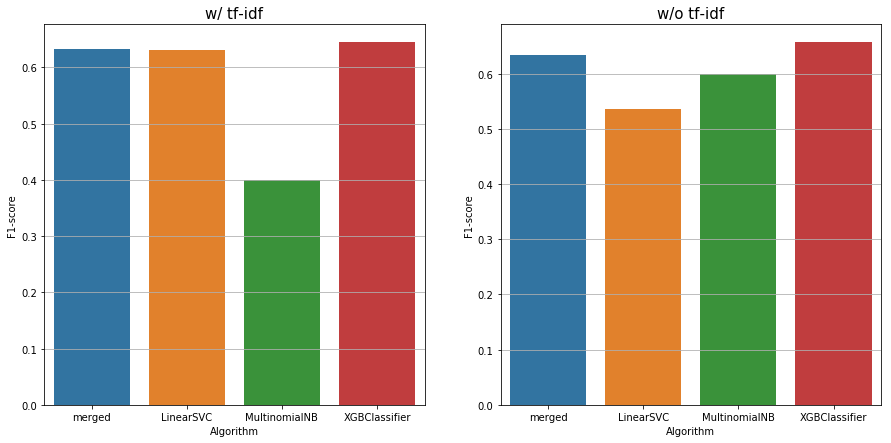

In [274]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.barplot(data=score_tfidf)

plt.xlabel('Algorithm', size = 10)
plt.ylabel('F1-score', size = 10)
plt.title('w/ tf-idf', size=15)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)
plt.grid(True, axis='y')


plt.subplot(1,2,2)
plt.xlabel('Algorithm', size = 10)
plt.ylabel('F1-score', size = 10)
plt.title('w/o tf-idf', size=15)
plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10, rotation=0)

sns.barplot(data=score_tfidf_false)
plt.grid(True, axis='y')



### Try multioutput classification

In [60]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    '''
    transform mbti to binary vector
    '''
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    '''
    transform binary vector to mbti personality
    '''
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [61]:
# Feed classifier to MultiOutputCLassifier
clf = AdaBoostClassifier()
# clf = xgb.XGBClassifier()
# classifier를 XGBoost Classifier로 바꿔보기
multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_classifier.fit(X_tfidf, list_personality_bin)
preds = multi_target_classifier.predict(X_tfidf)

preds_t = [translate_back(p) for p in preds]
vec1 = data.type ==  preds_t
for i in range(4):
    print("f1 score for %s:\n%s" % (titles[i],
                                    f1_score(np.array(list_personality_bin)[:,i], preds[:,i])))


f1 score for Extraversion (E) - Introversion (I):
0.6466821885913854
f1 score for Sensation (S) - INtuition (N):
0.5565307176045432
f1 score for Thinking (T) - Feeling (F):
0.8140120967741935
f1 score for Judgement (J) - Perception (P):
0.8449598246895544


In [61]:
# Feed classifier to MultiOutputCLassifier
# clf = AdaBoostClassifier()
clf = xgb.XGBClassifier()
# classifier를 XGBoost Classifier로 바꿔보기
multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_classifier.fit(X_tfidf, list_personality_bin)
preds = multi_target_classifier.predict(X_tfidf)

preds_t = [translate_back(p) for p in preds]
vec1 = data.type ==  preds_t
for i in range(4):
    print("f1 score for %s:\n%s" % (titles[i],
                                    f1_score(np.array(list_personality_bin)[:,i], preds[:,i])))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

f1 score for Extraversion (E) - Introversion (I):
0.9989984977466199
f1 score for Sensation (S) - INtuition (N):
0.9991638795986623
f1 score for Thinking (T) - Feeling (F):
0.9993719381987187
f1 score for Judgement (J) - Perception (P):
0.9979986657771848


f1 score whyrano.....

In [76]:
# Stratified cross val for multi-output
X = list_posts
y = np.array(list_personality_bin)

# clf = AdaBoostClassifier()
# classifier를 XGBoost Classifier로 바꿔보기
clf = xgb.XGBClassifier()
kf = StratifiedShuffleSplit(n_splits=10)
# 10-fold CV

list_score = []
list_score_per_class= []

for train, test in kf.split(X, y):
    X_train, X_test, y_train, y_test = \
        X[train], X[test], y[train], y[test]

    X_train = cntizer.fit_transform(X_train)
    X_test = cntizer.transform(X_test)
    
    X_train = tfizer.fit_transform(X_train).toarray()
    X_test = tfizer.transform(X_test).toarray()

    multi_target_classifier = MultiOutputClassifier(clf, n_jobs=-1)
    multi_target_classifier.fit(X_train, y_train)
    preds = multi_target_classifier.predict(X_test)
    
    rev_preds = np.array([translate_back(p) for p in preds]) 
    rev_test = np.array([translate_back(p) for p in y_test])
    score = f1_score(rev_test,rev_preds, average='weighted')
    list_score.append(score)
    print('\nTotal score: %s' % f1_score(rev_test,rev_preds, average='weighted'))

    list_temp =[]
    for i in range(4):
        score_per_class = f1_score(y_test[:,i], preds[:,i])
        list_temp.append(score_per_class)
        print(score_per_class)
    list_score_per_class.append(list_temp)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Total score: 0.4975093810215537
0.5352941176470588
0.4946236559139786
0.8109452736318409
0.8215919487648673

Total score: 0.5299897110100805
0.5921787709497207
0.5499999999999999
0.8044280442804428
0.8464285714285713


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Total score: 0.5322638616037645
0.6135693215339233
0.5445544554455446
0.7860696517412935
0.8282097649186257

Total score: 0.5075288381508517
0.5965909090909091
0.5108695652173912
0.8010139416983523
0.813466787989081

Total score: 0.5303345520970726
0.5930232558139534
0.4421052631578947
0.7814910025706941
0.848868778280543

Total score: 0.5354771676073444
0.6467391304347826
0.5052631578947367
0.8095238095238096
0.8330341113105924

Total score: 0.512922235171574
0.6324786324786325
0.47668393782383417
0.7959949937421777
0.8213961922030825

Total score: 0.5360477738838602
0.6136986301369863
0.5106382978723405
0.7835820895522388
0.8320895522388061


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Total score: 0.5341616932855452
0.6260869565217392
0.5870646766169154
0.8129675810473816
0.8268876611418048

Total score: 0.5069391886455108
0.6404494382022471
0.48167539267015713
0.7928843710292248
0.8287292817679557


AdaBoost

In [77]:
list_score_per_class = np.array(list_score_per_class)
print('Mean score per classes: %s' % np.around(list_score_per_class.mean(axis=0),2))

Mean score per classes: [0.61 0.51 0.8  0.83]


XGBoost

In [73]:
list_score_per_class = np.array(list_score_per_class)
print('Mean score per classes: %s' % np.around(list_score_per_class.mean(axis=0), 2))

Mean score per classes: [0.65 0.56 0.83 0.84]


AdaBoostClassifier를 사용했을 때  


|Attribute| Extraversion (E) - Introversion (I)  | Sensation (S) - INtuition (N)  | Thinking (T) - Feeling (F)  | Judgement (J) - Perception (P)  |   
|:-:|---|---|---|---|
|F1-Score|0.61 | 0.51 | 0.8 |  0.83|    
  
XGBoostClassifier를 사용했을 때  


|Attribute| Extraversion (E) - Introversion (I)  | Sensation (S) - INtuition (N)  | Thinking (T) - Feeling (F)  | Judgement (J) - Perception (P)  |   
|:-:|---|---|---|---|
|F1-Score|0.65 | 0.56 | 0.83 |  0.84| 